In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [ ]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

2023-10-08 12:19:05.804721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 12:19:05.804770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 12:19:05.804813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 12:19:05.813578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [ ]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

## Data-driven Approach with small data

### Load and Sample Data

In [ ]:
Plate_data = np.load('../Plate_data.npy')

loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

In [ ]:
tr_sample = np.array([np.where(loc[:,0] == i) for i in [2, 5, 8]]).reshape(-1,)
x_sample = loc[tr_sample, :]
u_sample = u[tr_sample, :]
v_sample = v[tr_sample, :]

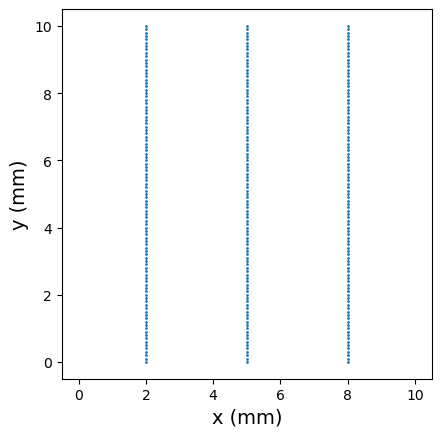

In [ ]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=1)
plt.xlabel('x (mm)', fontsize=14)
plt.ylabel('y (mm)', fontsize=14)
plt.axis('square')
plt.xlim([-0.5, a+0.5])
plt.show()

In [ ]:
observe_u = dde.icbc.PointSetBC(x_sample, u_sample, component=0)
observe_v = dde.icbc.PointSetBC(x_sample, v_sample, component=1)

2023-10-08 12:23:07.656130: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-08 12:23:07.657034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


### Define Geometry

In [ ]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])

data = dde.data.PDE(geom,
                    None,
                    [observe_u, observe_v],
                    num_domain=0,
                    num_boundary=0,
                    num_test=100)

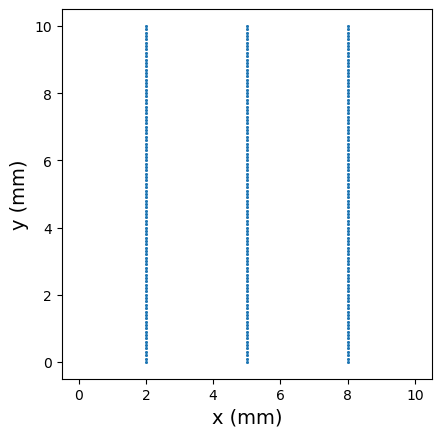

In [ ]:
plt.scatter(data.train_x[:, 0], data.train_x[:, 1], s=1)
plt.xlabel('x (mm)', fontsize=14)
plt.ylabel('y (mm)', fontsize=14)
plt.axis('square')
plt.xlim([-0.5, a+0.5])
plt.show()

### Define Network and Hyper-parameters

In [ ]:
layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.009577 s



### Train (Adam Optimizer)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-08 12:28:02.228158: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f7e2d21ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 12:28:02.228213: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-08 12:28:02.239647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 12:28:02.870092: I tensorflow/compiler

Step      Train loss              Test loss               Test metric
0         [2.09e-01, 3.06e-01]    [2.09e-01, 3.06e-01]    []  
Epoch 1: train loss improved from inf to 5.15e-01, saving model to models/small-1.ckpt ...

1000      [7.12e-06, 3.01e-06]    [7.12e-06, 3.01e-06]    []  
Epoch 1000: train loss improved from 5.15e-01 to 1.01e-05, saving model to models/small-1000.ckpt ...

2000      [4.53e-06, 1.16e-06]    [4.53e-06, 1.16e-06]    []  
Epoch 2000: train loss improved from 1.01e-05 to 5.68e-06, saving model to models/small-2000.ckpt ...

3000      [1.19e-07, 2.86e-07]    [1.19e-07, 2.86e-07]    []  
Epoch 3000: train loss improved from 5.68e-06 to 4.05e-07, saving model to models/small-3000.ckpt ...

4000      [3.15e-07, 2.81e-07]    [3.15e-07, 2.81e-07]    []  
5000      [1.04e-07, 1.38e-07]    [1.04e-07, 1.38e-07]    []  
Epoch 5000: train loss improved from 4.05e-07 to 2.42e-07, saving model to models/small-5000.ckpt ...

6000      [9.78e-08, 3.45e-06]    [9.78e-08, 3.4

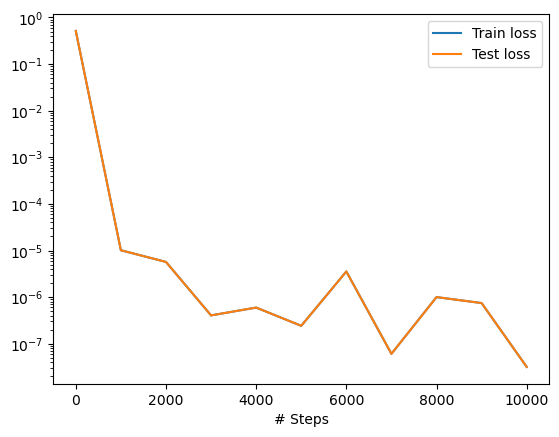

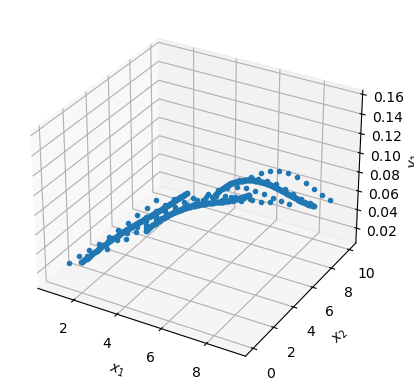

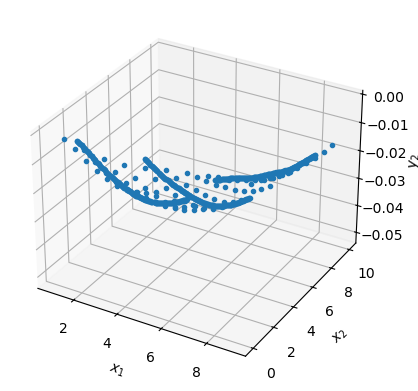

In [ ]:
checkpointer = dde.callbacks.ModelCheckpoint(
    "models/small", verbose=1, save_better_only=True 
)

loss_history, train_state = model.train(iterations=10000, callbacks=[checkpointer])

dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam Optimizer)

In [ ]:
def check_stress(net, X):
    X = tf.constant(X)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        disp = net(X)
        u_pred = tf.reshape(disp[:, 0], [-1, 1])
        v_pred = tf.reshape(disp[:, 1], [-1, 1])
    
    du_X = tape.gradient(u_pred, X)
    dv_X = tape.gradient(v_pred, X)

    du_x, du_y = du_X[:, 0], du_X[:, 1]
    dv_x, dv_y = dv_X[:, 0], dv_X[:, 1]

    sig_xx = tf.reshape( (du_x + nu*dv_y)*E/(1-nu**2), [-1, 1] )
    sig_yy = tf.reshape( (dv_y + nu*du_x)*E/(1-nu**2), [-1, 1] )
    
    return sig_xx, sig_yy

In [ ]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

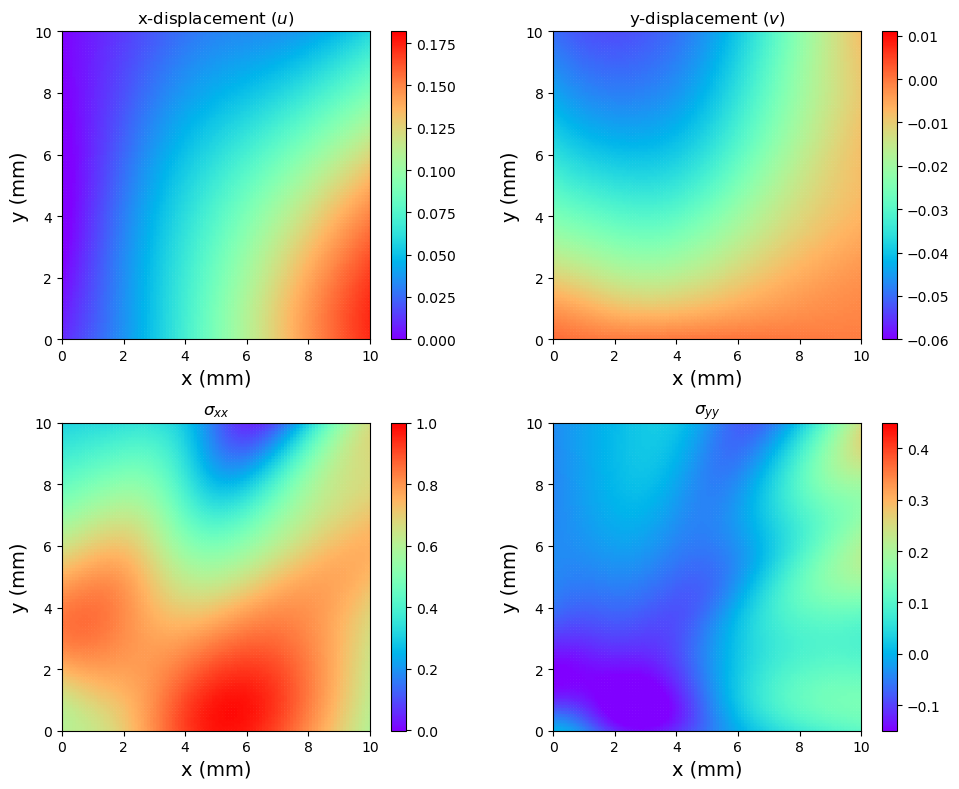

In [ ]:
samples = geom.uniform_points(10000)
small_disp = model.predict(samples)
small_sg = np.hstack(check_stress(model.net, samples))
small_result = np.hstack([small_disp, small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.014933 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [2.07e-08, 1.11e-08]    [2.07e-08, 1.11e-08]    []  
10122     [3.74e-09, 2.71e-09]    [3.74e-09, 2.71e-09]    []  

Best model at step 10122:
  train loss: 6.45e-09
  test loss: 6.45e-09
  test metric: []

'train' took 47.919317 s



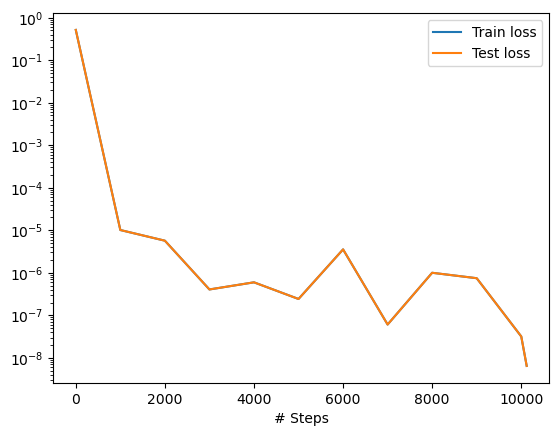

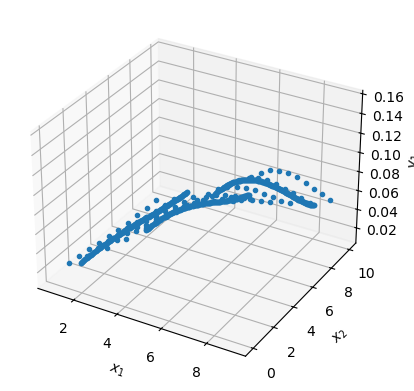

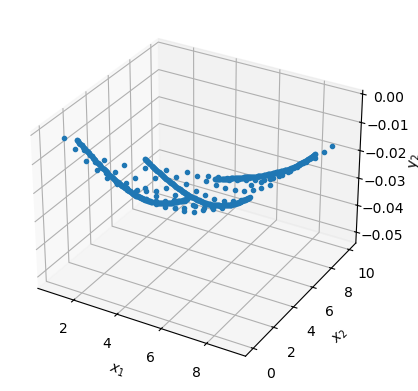

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam + L-BFGS)

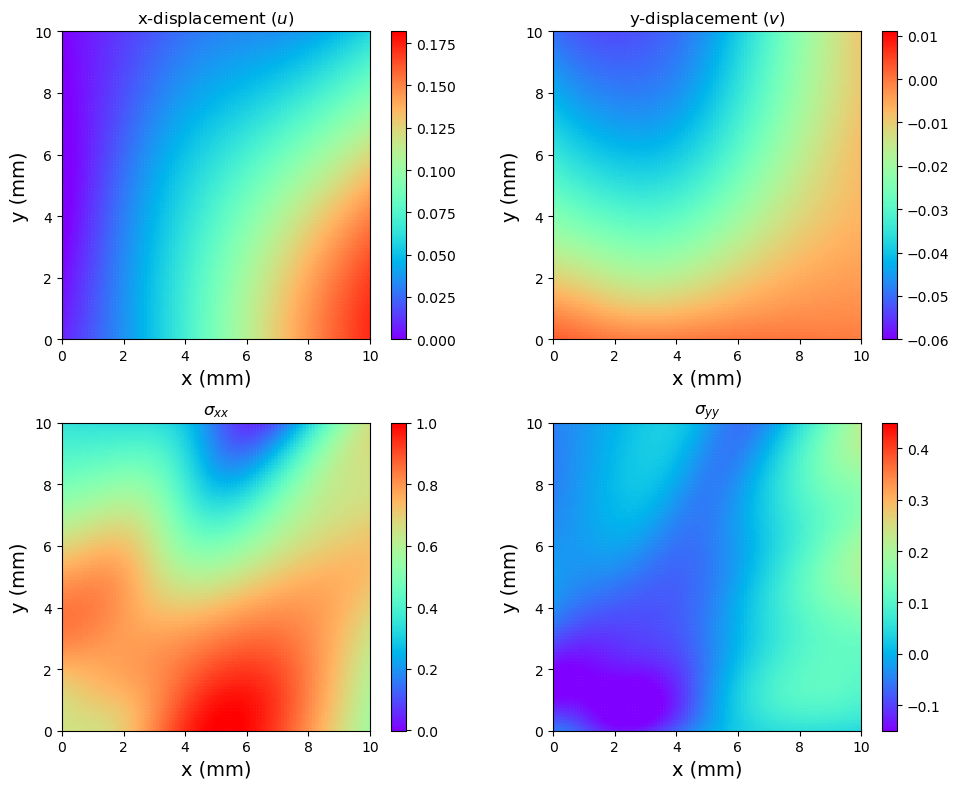

In [ ]:
samples = geom.uniform_points(10000)
small_disp = model.predict(samples)
small_sg = np.hstack(check_stress(model.net, samples))
small_result = np.hstack([small_disp, small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Save and Restore

In [ ]:
model.predict(samples)

array([[ 0.00778715,  0.00267083],
       [ 0.00750365,  0.00215762],
       [ 0.00722168,  0.00162641],
       ...,
       [ 0.06134586, -0.00938483],
       [ 0.0597663 , -0.0093466 ],
       [ 0.05819409, -0.00930817]], dtype=float32)

In [ ]:
model.save('model/small', verbose=1)

Epoch 10122: saving model to model/small-10122.ckpt ...



'model/small-10122.ckpt'

In [ ]:
mm = dde.Model(data, net)

In [ ]:
mm.restore('model/small-10122.ckpt')

In [ ]:
mm.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.006436 s



In [ ]:
mm.predict(samples)

array([[ 0.00778715,  0.00267083],
       [ 0.00750365,  0.00215762],
       [ 0.00722168,  0.00162641],
       ...,
       [ 0.06134586, -0.00938483],
       [ 0.0597663 , -0.0093466 ],
       [ 0.05819409, -0.00930817]], dtype=float32)

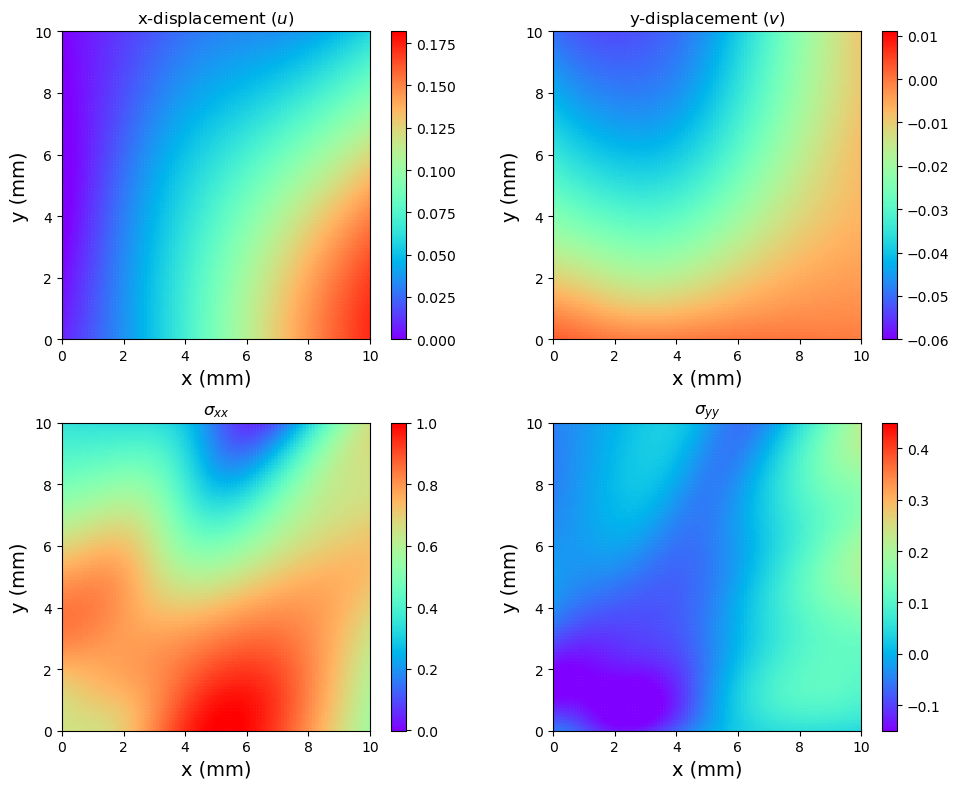

In [ ]:
samples = geom.uniform_points(10000)
small_disp = mm.predict(samples)
small_sg = np.hstack(check_stress(mm.net, samples))
small_result = np.hstack([small_disp, small_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=small_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()